<a href="https://colab.research.google.com/github/ArtyomShabunin/PINNModels/blob/main/train_seq2seq_model_v3__with_pinn_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/RNN-models')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Seq2Seq –Ω–µ–π—Ä–æ–Ω–Ω–∞—è —Å–µ—Ç—å

In [2]:
!pip install mlflow==2.22.1 dagshub --quiet
!pip install pytorch-lightning

import pytorch_lightning as pl
from pytorch_lightning import callbacks, cli_lightning_logo, LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.mlflow import MLFlowLogger

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import Dataset, DataLoader, random_split
torch.set_printoptions(precision=3, sci_mode=False)

import matplotlib.pyplot as plt

import json
import numpy as np

import random


from time import time
import math
from copy import deepcopy
import pandas as pd
from datetime import datetime

import glob
import zipfile
import joblib
from tqdm import tqdm
from IPython.display import clear_output

import os
import dagshub
import mlflow
from mlflow.models import infer_signature

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

from seqdataset import SequenceDataset

from typing import List

from numpy import cumsum, ones

In [3]:

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

    random.seed(seed)

set_seeds(4)

MLFlow –∫—Ä–µ–¥—ã

In [4]:
dagshub.init("gas-prop-net", "pranamodeling", mlflow=True)

Accessing as pranamodeling

Initialized MLflow to track repo "pranamodeling/gas-prop-net"

Repository pranamodeling/gas-prop-net initialized!

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—É—á–µ–Ω–∏—è

In [6]:
parquetFileList = glob.glob('/content/drive/MyDrive/RNN-models-data/data_4/*.gzip')
# parquetFileList = glob.glob('/content/drive/MyDrive/RNN-models-data/data_3/*.gzip')
print("–ß–∏—Å–ª–æ —Ñ–∞–π–ª–æ–≤: ", len(parquetFileList))

–ß–∏—Å–ª–æ —Ñ–∞–π–ª–æ–≤:  80


In [7]:
# (pd.read_parquet(parquetFileList[0]).loc[:, ['datetime']].astype('datetime64[ns]').astype('int64')/1000000000).astype('int64')

In [8]:
# parquetFileList = parquetFileList[:2]

In [9]:
def get_training_and_testing_sets(file_list):
    split = 0.7
    file_list = [f for f in file_list]
    random.shuffle(file_list)
    split_index = math.floor(len(file_list) * split)
    training = file_list[:split_index]
    testing = file_list[split_index:]
    return training, testing

In [10]:
train_files, test_files = get_training_and_testing_sets(parquetFileList)

–í—Ö–æ–¥–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã

In [11]:
input_data = [
    # 'GTA1.DBinPU.Aldi', # –£–ü –¥–æ–∑–∞—Ç–æ—Ä–∞ —Ç–æ–ø–ª–∏–≤–∞, –≥—Ä–∞–¥
    'GTA1.DBinPU.P', # –∞–∫—Ç–∏–≤–Ω–∞—è –º–æ—â–Ω–æ—Å—Ç—å –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, –ú–í—Ç
    'GTA1.DBinPU.Ptgpd', # –¥–∞–≤–ª–µ–Ω–∏–µ —Ç–æ–ø–ª–∏–≤–Ω–æ–≥–æ –≥–∞–∑–∞ –ø–µ—Ä–µ–¥ –¥–æ–∑–∞—Ç–æ—Ä–æ–º, –ú–ü–∞
    'GTA1.DBinPU.Ttgvh', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ —Ç–æ–ø–ª–∏–≤–Ω–æ–≥–æ –≥–∞–∑–∞ –ø–µ—Ä–µ–¥ –¥–æ–∑–∞—Ç–æ—Ä–æ–æ–º, –°
    'GTA1.DBinPU.Ies', # –≤—ã—Ö–æ–¥–Ω–æ–π —Ç–æ–∫ –≤ —Ü–µ–ø–∏ —ç–ª–µ–∫—Ç—Ä–æ—Å—Ç–∞—Ä—Ç–µ—Ä–∞, –ê
    # 'GTA1.DBinPU.nst', # —á–∞—Å—Ç–æ—Ç–∞ –≤—Ä–∞—â–µ–Ω–∏—è —Ä–æ—Ç–æ—Ä–∞ —Å–∏–ª–æ–≤–æ–π —Ç—É—Ä–±–∏–Ω—ã, –æ–±/–º–∏–Ω
    'GTA1.DBinPU.Tn', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –Ω–∞—Ä—É–∂–Ω–æ–≥–æ –≤–æ–∑–¥—É—Ö–∞, –°
    'GTA1.DBinPU.Bo', # –±–∞—Ä–æ–º–µ—Ç—Ä–∏—á–µ—Å–∫–æ–µ –¥–∞–≤–ª–µ–Ω–∏–µ, –∫–ü–∞
    'GTA1.DBinPU.fi', # –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–∞—è –≤–ª–∞–∂–Ω–æ—Å—Ç—å –Ω–∞—Ä—É–∂–Ω–æ–≥–æ –≤–æ–∑–¥—É—Ö–∞, %
    'GTA1.DBinPU.Alzzo', # –ø–æ–ª–æ–∂–µ–Ω–∏–µ –ó–ó–û, %
    # –≤—Ä–µ–º—è
]

–í—ã—Ö–æ–¥–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã

In [14]:
output_data = [
    # 'GTA1.DBinPU.P', # –∞–∫—Ç–∏–≤–Ω–∞—è –º–æ—â–Ω–æ—Å—Ç—å –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, –ú–í—Ç
    'GTA1.DBinPU.Aldi', # –£–ü –¥–æ–∑–∞—Ç–æ—Ä–∞ —Ç–æ–ø–ª–∏–≤–∞, –≥—Ä–∞–¥
    'GTA1.DBinPU.ntk', # —á–∞—Å—Ç–æ—Ç–∞ –≤—Ä–∞—â–µ–Ω–∏—è —Ä–æ—Ç–æ—Ä–∞ —Ç—É—Ä–±–æ–∫–æ–º–ø—Ä–µ—Å—Å–æ—Ä–∞, –æ–±/–º–∏–Ω
    'GTA1.DBinPU.nst', # —á–∞—Å—Ç–æ—Ç–∞ –≤—Ä–∞—â–µ–Ω–∏—è —Ä–æ—Ç–æ—Ä–∞ —Å–∏–ª–æ–≤–æ–π —Ç—É—Ä–±–∏–Ω—ã, –æ–±/–º–∏–Ω
    # 'GTA1.DBinPU.Ies', # –≤—ã—Ö–æ–¥–Ω–æ–π —Ç–æ–∫ –≤ —Ü–µ–ø–∏ —ç–ª–µ–∫—Ç—Ä–æ—Å—Ç–∞—Ä—Ç–µ—Ä–∞, –ê
    'GTA1.DBinPU.Alvna', # –ø–æ–ª–æ–∂–µ–Ω–∏–µ –í–ù–ê, –≥—Ä–∞–¥
    'GTA1.DBinPU.Qtg', # —Ä–∞—Å—Ö–æ–¥ —Ç–æ–ø–ª–∏–≤–Ω–æ–≥–æ –≥–∞–∑–∞, –º3/—á–∞—Å
    'GTA1.DBinPU.Pk', # –¥–∞–≤–ª–µ–Ω–∏–µ –∑–∞ –∫–æ–º–ø—Ä–µ—Å—Å–æ—Ä–æ–º, –ú–ü–∞
    'GTA1.DBinPU.Tvh1', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –≤–æ–∑–¥—É—Ö–∞ –ø–µ—Ä–µ–¥ –ì–¢–î, –°
    'GTA1.DBinPU.Pvh', # –¥–∞–≤–ª–µ–Ω–∏–µ –≤–æ–∑–¥—É—Ö–∞ –ø–µ—Ä–µ–¥ –ì–¢–î, –∫–ü–∞
    'GTA1.DBinPU.Tk', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –≤–æ–∑–¥—É—Ö–∞ –∑–∞ –∫–æ–º–ø—Ä–µ—Å—Å–æ—Ä–æ–º, –°
    'GTA1.DBinPU.Tt', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –≥–∞–∑–æ–≤ –∑–∞ —Å–∏–ª–æ–≤–æ–π —Ç—É—Ä–±–∏–Ω–æ–π, –°
    'GTA1.DBinPU.Pvyhlg', # –¥–∞–≤–ª–µ–Ω–∏–µ –≥–∞–∑–æ–≤ –∑–∞ —Å–∏–ª–æ–≤–æ–π —Ç—É—Ä–±–∏–Ω–æ–π, –∫–ü–∞
]

In [16]:
output_no_meas_data = [
    'm_air', # —Ä–∞—Å—Ö–æ–¥ –≤–æ–∑–¥—É—Ö–∞ —á–µ—Ä–µ–∑ –∫–æ–º–ø—Ä–µ—Å—Å–æ—Ä, –∫–≥/—Å
    'etac', # –ö–ü–î –∫–æ–º–ø—Ä–µ—Å—Å–æ—Ä–∞
    'LHV', # —Ç–µ–ø–ª–æ—Ç–∞ —Å–≥–æ—Ä–∞–Ω–∏—è —Ç–æ–ø–ª–∏–≤–∞, –î–∂/–∫–≥
    't_ggt_in', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –ø–µ—Ä–µ–¥ —Ç—É—Ä–±–∏–Ω–æ–π –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, C
    'p_ggt_in', # –¥–∞–≤–ª–µ–Ω–∏–µ –ø–µ—Ä–¥ —Ç—É—Ä–±–∏–Ω–æ–π –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, –ú–ü–∞(–æ—Ç–Ω.)
    't_ggt_out', # —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –∑–∞ —Ç—É—Ä–±–∏–Ω–æ–π –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, C
    'p_ggt_out', # –¥–∞–≤–ª–µ–Ω–∏–µ –∑–∞ —Ç—É—Ä–±–∏–Ω–æ–π –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, –ú–ü–∞(–æ—Ç–Ω.)
    'eta_ggt', # –ö–ü–î —Ç—É—Ä–±–∏–Ω—ã –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞
    'eta_pt', # –ö–ü–î —Å–∏–ª–æ–≤–æ–π —Ç—É—Ä–±–∏–Ω—ã
]

## Physics loss

### –ú–æ–¥–µ–ª—å –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ —Å–≤–æ–π—Å—Ç–≤ —Å–º–µ—Å–µ–π –≥–∞–∑–æ–≤

In [ ]:
class GasMixturePropertiesNN(nn.Module):
    def __init__(self, logged_model_uri: str, logged_info_uri: str, freeze: bool = True):
        super().__init__()
        # –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –æ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏
        self.raw_model = mlflow.pyfunc.load_model(logged_model_uri).get_raw_model()

        # –ó–∞–º–æ—Ä–æ–∑–∫–∞ –≤–µ—Å–æ–≤
        if freeze:
            for param in self.raw_model.parameters():
                param.requires_grad = False

        with open(mlflow.artifacts.download_artifacts(logged_info_uri)) as f:
            self.model_info = json.load(f)

        # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º mean –∏ std –≤ —Ç–µ–Ω–∑–æ—Ä—ã
        self.register_buffer('input_mean', torch.tensor(self.model_info['scaler_input']['mean_'], dtype=torch.float32))
        self.register_buffer('input_std', torch.tensor(self.model_info['scaler_input']['std_'], dtype=torch.float32))
        self.register_buffer('output_mean', torch.tensor(self.model_info['scaler_output']['mean_'], dtype=torch.float32))
        self.register_buffer('output_std', torch.tensor(self.model_info['scaler_output']['std_'], dtype=torch.float32))

    def forward(self, x1: torch.Tensor, x2: torch.Tensor, x3: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            inputs: Tensor —Ä–∞–∑–º–µ—Ä–∞ (batch_size, n_features) ‚Äî –¥–∞–≤–ª–µ–Ω–∏–µ, —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞/—ç–Ω—Ç–∞–ª—å–ø–∏—è, —Å–æ—Å—Ç–∞–≤ —Å–º–µ—Å–∏ –∏ —Ç.–¥.
        Returns:
            Tensor —Ä–∞–∑–º–µ—Ä–∞ (batch_size, n_outputs) ‚Äî —Ñ–∏–∑–∏—á–µ—Å–∫–∏–µ —Å–≤–æ–π—Å—Ç–≤–∞: T/h, rho, s, mu, lambda, cp
        """

        inputs = torch.cat([x1, x2, x3], axis=1)

        # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
        x_norm = (inputs - self.input_mean) / self.input_std

        # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
        y_norm = self.raw_model(x_norm)

        # –û–±—Ä–∞—Ç–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
        y = y_norm * self.output_std + self.output_mean

        return {key:y[:,i:i+1] for i, key in enumerate(self.model_info['output'])}

In [ ]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–µ–π
gas_pHX = GasMixturePropertiesNN(
    logged_model_uri='runs:/7febe97b33db4e978445b2290c9453d1/mdllol',
    logged_info_uri='mlflow-artifacts:/e7cc815685774faa9f6b047a083f2220/7febe97b33db4e978445b2290c9453d1/artifacts/info.json'
)

gas_pTX = GasMixturePropertiesNN(
    logged_model_uri='runs:/71abefa7c4d5421abbb48f9dd3b7f1b8/mdllol',
    logged_info_uri='mlflow-artifacts:/814e64636dca42cfbac0984ece9bc5fd/71abefa7c4d5421abbb48f9dd3b7f1b8/artifacts/info.json'
)

gas_pSX = GasMixturePropertiesNN(
    logged_model_uri='runs:/6511acddd9874890ba90d6c889756c81/mdllol',
    logged_info_uri='mlflow-artifacts:/25c2c06c1c7f43d3bb10a131022afe84/6511acddd9874890ba90d6c889756c81/artifacts/info.json'
)

–£ –º–æ–¥–µ–ª–∏ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å –¥–≤–∞ output, –æ–¥–∏–Ω —Å –∏–∑–º–µ—Ä—è–µ–º—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏, –¥—Ä—É–≥–æ–π —Å –Ω–µ–∏–∑–º–µ—Ä—è–µ–º—ã–º–∏.  
–î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –≤—ã—Ö–æ–¥–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: —Ä–∞—Å—Ö–æ–¥ –≤–æ–∑–¥—É—Ö–∞, –ö–ü–î –∫–æ–º–ø—Ä–µ—Å—Å–æ—Ä–∞, –Ω–∏–∑—à–∞—è —Ç–µ–ø–ª–æ—Ç–∞ —Å–≥–æ—Ä–∞–Ω–∏—è —Ç–æ–ø–ª–∏–≤–∞, –ö–ü–î —Ç—É—Ä–±–∏–Ω—ã –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ –∑–∞ —Ç—É—Ä–±–∏–Ω–æ–π –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞, –¥–∞–≤–ª–µ–Ω–∏–µ –∑–∞ —Ç—É—Ä–±–∏–Ω–æ–π –≥–∞–∑–æ–≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞   
–í —Ñ–∏–∑–∏—á–µ—Å–∫–∏–µ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è –º–æ–∂–Ω–æ –∑–∞–ø–∏—Å–∞—Ç—å –±–∞–ª–∞–Ω—Å –º–æ—â–Ω–æ—Å—Ç–∏

In [38]:
def compute_time_derivatives(y_pred, t):
    dYdt = torch.autograd.grad(
        outputs=y_pred,
        inputs=t,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    return dYdt

In [39]:
def physics_loss(t, x_input, y_pred):

    # –†–∞—Å—á–µ—Ç —Å–æ—Å—Ç–∞–≤–∞ –≤–æ–∑–¥—É—Ö–∞
    # –≠—Ç–∞–ª–æ–Ω–Ω—ã–π —Å–æ—Å—Ç–∞–≤ –≤–æ–∑–¥—É—Ö–∞
    # Oxygen, Argon, Water, Carbondioxide, Nitrogen
    # –ú–∞—Å—Å–æ–≤—ã–π —Å–æ—Å—Ç–∞–≤ (–º–∞—Å—Å–æ–≤—ã–µ –¥–æ–ª–∏)
    Xref = torch.tensor([0.23, 0.005, 0.015, 1e-6, 0.75-1e-6])
    # –ú–æ–ª—å–Ω—ã–µ –º–∞—Å—Å—ã (–∫–≥/–º–æ–ª—å)
    MMX = torch.tensor([0.0319988, 0.039948, 0.01801528, 0.0440095, 0.0280134])

    # –ß–∏—Å–ª–æ –º–æ–ª–µ–π –∫–∞–∂–¥–æ–≥–æ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–∞ (–º–∞—Å—Å–∞ / –º–æ–ª—å–Ω–∞—è –º–∞—Å—Å–∞)
    mol_numbers = Xref / MMX

    # –°—É–º–º–∞—Ä–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–æ–ª–µ–π
    mol_total = mol_numbers.sum()

    # –ú–æ–ª—å–Ω—ã–µ –¥–æ–ª–∏
    Yref = mol_numbers / mol_total

    # –†–∞—Å–ø–∞–∫–æ–≤–∫–∞
    y_meas, y_no_meas = y_pred

    tamb, pamb, RH = input_data[..., 4], input_data[..., 5], input_data[..., 6]

    # tamb = torch.tensor([15])
    # pamb = torch.tensor([101325])
    # RH = torch.tensor([0.8])


    Psat_a = 0.6121*torch.exp((18.678-(tamb)/234.5)*(tamb)/(257.14+tamb))*1e3;
    Psat_b = 0.61115*torch.exp((23.036-(tamb)/333.7)*(tamb)/(279.82+tamb))*1e3;

    Psat = torch.where(tamb > 0, Psat_a, Psat_b)

    Ph2o = RH * Psat
    yh2o = Ph2o / pamb

    Y = Yref*(1-yh2o)/(1-Yref[3])
    Y[2] = yh2o

    numerator = Y * MMX
    denominator = numerator.sum(dim=-1, keepdim=True)
    X_air = numerator / denominator

    # –ö–æ–º–ø—Ä–µ—Å—Å–æ—Ä

    pc_out, Tc_out = y_meas[..., 5], y_meas[..., 8]
    pc_in, Tc_in = y_meas[..., 5], y_meas[..., 8]
    # –¥–∞–ª–µ–Ω–∏—è –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø—Ä–∏–≤–µ—Å—Ç–∏ –∫ –µ–¥–∏–Ω–æ–π —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏

    state_c_in = gas_pSX(pc_in, Tc_in+273.15, X_air)
    state_c_out = gas_pTX(pc_out, Tc_out+273.15, X_air)
    state_c_iso = gas_pSX(pc_out, state_in['s'], X_air)

    eta_c = (state_c_iso['h'] - state_c_in['h']) / (state_c_out['h'] - state_c_in['h'])

    m_air_hat, etac_hat = y_no_meas[..., 0], y_no_meas[..., 1]

    Pc = m_air_hat * (state_c_out['h'] - state_c_in['h']) # –í–æ–∑–º–æ–∂–Ω–æ –∏–º–µ–µ—Ç —Å–º—ã—Å–ª —É—á–µ—Å—Ç—å –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏–µ –ø–æ—Ç–µ—Ä–∏


    # –ö–ê–ú–ï–†–ê –°–ì–û–†–ê–ù–ò–Ø

    # –ú–æ–ª—è—Ä–Ω—ã–µ –º–∞—Å—Å—ã, –∫–≥/–º–æ–ª—å
    MM = {
        'CH4': 0.01604246,
        'O2':  0.0319988,
        'H2O': 0.01801528,
        'CO2': 0.0440095
    }

    # –°–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –∏–Ω–¥–µ–∫—Å–æ–≤ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤ –≤ –≤–æ–∑–¥—É—Ö–µ
    IDX = {
        'O2': 0,
        'Ar': 1,
        'H2O': 2,
        'CO2': 3,
        'N2': 4
    }

    # –°–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –∏–Ω–¥–µ–∫—Å–æ–≤ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤ –≤ —Ç–æ–ø–ª–∏–≤–µ
    FUEL_IDX = {
        'N2': 0,
        'CO2': 1,
        'CH4': 2
    }

    # –≠—Ç–∞–ª–æ–Ω–Ω—ã–π —Å–æ—Å—Ç–∞–≤ —Ç–æ–ø–ª–∏–≤–∞ (N2, CO2, CH4)
    X_fuel = torch.tensor([0.02,0.012,0.968])


    m_fuel = y_meas[..., 4] # –Ω—É–∂–µ–Ω –ø–µ—Ä–µ—Å—á–µ—Ç –æ–±—ä–µ–º–Ω–æ–≥–æ —Ä–∞—Å—Ö–æ–¥–∞ –≤ –º–∞—Å—Å–æ–≤—ã–π
    LHV_hat = y_no_meas[..., 2]
    LHV = 33500.0e3 # –ó–∞–¥–∞–Ω–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ

    # –ú–∞—Å—Å—ã –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤ –≤–æ–∑–¥—É—Ö–∞ (5 –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤)
    M_air = m_air_hat * X_air

    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–æ–ø–ª–∏–≤–æ –≤ 5-–∫–æ–º–ø–æ–Ω–µ–Ω—Ç–Ω—ã–π –≤–µ–∫—Ç–æ—Ä
    M_fuel = torch.zeros_like(M_air)  # (batch, 5)
    M_fuel[:, IDX['N2']]  = m_fuel * X_fuel[:, FUEL_IDX['N2']]
    M_fuel[:, IDX['CO2']] = m_fuel * X_fuel[:, FUEL_IDX['CO2']]
    m_CH4 = m_fuel * X_fuel[:, FUEL_IDX['CH4']].unsqueeze(1)  # (batch, 1)

    # –ú–æ–ª—è—Ä–Ω—ã–π —Ä–∞—Å—Ö–æ–¥ CH4 (–∫–º–æ–ª—å/—Å)
    n_CH4 = m_CH4 / MM['CH4']

    # —É—á–µ—Ç –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–≥–æ –∫–∏—Å–ª–æ—Ä–æ–¥–∞
    m_O2_avail = M_air[:, IDX['O2']].unsqueeze(1)
    m_O2_needed = 2 * n_CH4 * MM['O2']
    lambda_ = m_O2_avail / (m_O2_needed + 1e-8)
    combustion_ratio = torch.clamp(lambda_, max=1.0, min=0.0)
    n_CH4_reacted = n_CH4 * combustion_ratio
    n_CH4_unburned = n_CH4 * (1.0 - combustion_ratio)
    m_CH4_unburned = n_CH4_unburned * MM['CH4']

    # –ú–∞—Å—Å—ã –ø—Ä–æ–¥—É–∫—Ç–æ–≤ —Ä–µ–∞–∫—Ü–∏–∏
    m_O2_react = 2 * n_CH4_reacted * MM['O2']
    m_H2O_prod = 2 * n_CH4_reacted * MM['H2O']
    m_CO2_prod = 1 * n_CH4_reacted * MM['CO2']

    # –ú–∞—Å—Å–∞ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤ –∑–∞ –∫–∞–º–µ—Ä–æ–π —Å–≥–æ—Ä–∞–Ω–∏—è
    M_out = M_air + M_fuel
    M_out -= m_O2_react.squeeze(1)
    M_out += m_H2O_prod.squeeze(1)
    M_out += m_CO2_prod.squeeze(1)

    # –ú–∞—Å—Å–æ–≤—ã–π —Å–æ—Å—Ç–∞–≤ –≤—ã—Ö–ª–æ–ø–Ω—ã—Ö –≥–∞–∑–æ–≤
    X_flue = M_out / M_out.sum(dim=1, keepdim=True)

    # –†–∞—Å—Ö–æ–¥ –≤—ã—Ö–ª–æ–ø–Ω—ã—Ö –≥–∞–∑–æ–≤
    m_flue = m_air_hat + m_fuel

    # –£—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è —ç–Ω–µ—Ä–≥–∏–∏ –¥–ª—è –∫–∞–º–µ—Ä—ã —Å–≥–æ—Ä–∞–Ω–∏—è
    h_ggt_in = (m_air_hat * state_c_out['h'] + m_fuel * LHV_hat) / m_flue

    # –î–∞–≤–ª–µ–Ω–∏–µ –∑–∞ –∫–∞–º–µ—Ä–æ–π —Å–≥–æ—Ä–∞–Ω–∏—è
    p_ggt_in = pc_out * (1 - 0.05)

    state_ggt_in = gas_pHX(p_ggt_in, h_ggt_in, X_flue)
    t_ggt_in = state_ggt_in['T']

    t_ggt_in_hat, p_ggt_in_hat = y_no_meas[..., 3], y_no_meas[..., 4]

    # –¢–£–†–ë–ò–ù–ê –ì–ê–ó–û–ì–ï–ù–ï–†–ê–¢–û–†–ê

    # –î–∞–≤–ª–µ–Ω–∏–µ –∑–∞ –∫–∞–º–µ—Ä–æ–π —Å–≥–æ—Ä–∞–Ω–∏—è
    p_ggt_in = pc_out * (1 - 0.05)

    state_ggt_in = gas_pTX(p_ggt_in_hat, t_ggt_in_hat, X_flue)
    t_ggt_out_hat, p_ggt_out_hat = y_no_meas[..., 5], y_no_meas[..., 6]
    state_ggt_out = gas_pTX(p_ggt_out_hat, t_ggt_out_hat, X_flue)

    state_ggt_iso = gas_pSX(p_ggt_in, state_ggt_in['s'], X_flue)
    eta_ggt = (state_ggt_in['h'] - state_ggt_out['h']) / (state_ggt_in['h'] - state_ggt_iso['h'])

    eta_ggt_hat = y_no_meas[..., 7]
    Pggt = m_flue * (state_ggt_in['h'] - state_ggt_out['h']) # –í–æ–∑–º–æ–∂–Ω–æ –∏–º–µ–µ—Ç —Å–º—ã—Å–ª —É—á–µ—Å—Ç—å –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏–µ –ø–æ—Ç–µ—Ä–∏

    # –ì–ê–ó–û–ì–ï–ù–ï–†–ê–¢–û–†
    # –°—é–¥–∞ –º–æ–∂–Ω–æ –¥–æ–±–∞–≤–∏—Ç—å —É—Ä–æ–≤–Ω–µ–Ω–∏–µ —Å –ø—Ä–æ–∏–∑–≤–æ–¥–Ω–æ–π –ø–æ —Å–∫–æ—Ä–æ—Å—Ç–∏ –≤—Ä–∞—â–µ–Ω–∏—è —Ä–æ—Ç–æ—Ä–∞ –ì–ì


    # –°–ò–õ–û–í–ê–Ø –¢–£–†–ë–ò–ù–ê

    Tpt_out, ppt_out = y_meas[..., 9], y_meas[..., 10]
    state_pt_out = gas_pTX(ppt_out, Tpt_out, X_flue)
    state_pt_iso = gas_pSX(p_ggt_out, state_ggt_out['s'], X_flue)
    eta_pt = (state_ggt_out['h'] - state_pt_iso['h']) / (state_ggt_out['h'] - state_pt_iso['h'])
    eta_pt_hat = y_no_meas[..., 8]

    Ppt_hat = m_flue * (state_pt_in['h'] - state_pt_out['h']) # –í–æ–∑–º–æ–∂–Ω–æ –∏–º–µ–µ—Ç —Å–º—ã—Å–ª —É—á–µ—Å—Ç—å –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏–µ –ø–æ—Ç–µ—Ä–∏




    # Losses
    # MSE(eta_c, etac_hat),
    # MSE(LHV, LHV_hat),
    # MSE(t_ggt_in, t_ggt_in_hat)
    # MSE(p_ggt_in, p_ggt_in_hat)
    # MSE(t_ggt_out, t_ggt_out_hat)
    # MSE(p_ggt_out, p_ggt_out_hat)
    # MSE(eta_ggt, eta_ggt_hat)
    # MSE(Pggt, Pc)
    # MSE(eta_pt, eta_pt_hat)
    # MSE(Ppt, Ppt_hat) # –Ω—É–∂–Ω–æ —É—á–µ—Å—Ç—å —á—Ç–æ –ø—Ä–∏ –º–æ—â–Ω–æ—Å—Ç–∏ —Ä–∞–≤–Ω–æ–π –Ω—É–ª—é –æ—à–∏–±–∫–∞ –Ω–µ –¥–æ–ª–∂–Ω–∞ —É—á–∏—Ç—ã–≤–∞—Ç—å—Å—è

tensor(34.918)

## –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler_input = StandardScaler()
# scaler_output = StandardScaler()

# scaler_input = MinMaxScaler()
# scaler_output = MinMaxScaler()

# for file in tqdm(parquetFileList):
#     df = pd.read_parquet(file)

#     input_values = df[input_data]
#     output_values = df[output_data]

#     scaler_input.partial_fit(input_values)
#     input_values = scaler_input.transform(input_values)

#     scaler_output.partial_fit(output_values)
#     output_values = scaler_output.transform(output_values)

# joblib.dump(scaler_input, "/content/drive/MyDrive/RNN-models/scaler_input_3.pkl")
# joblib.dump(scaler_output, "/content/drive/MyDrive/RNN-models/scaler_output_3.pkl")

In [40]:
scaler_input = joblib.load("/content/drive/MyDrive/RNN-models/scaler_input_2.pkl")
scaler_output = joblib.load("/content/drive/MyDrive/RNN-models/scaler_output_2.pkl")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [41]:
prep_input_info ={}
prep_output_info = {}
prep_input_info['scaler_input'] = {"min_": scaler_input.data_min_.tolist(), "max_": scaler_input.data_max_.tolist()}
prep_output_info['scaler_output'] = {"min_": scaler_output.data_min_.tolist(), "max_": scaler_output.data_max_.tolist()}

In [42]:
class SequenceDatasetForRNN(Dataset):

    '''
        shift - —Å–º–µ—â–µ–Ω–∏–µ –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö decodera –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ —ç–Ω–∫–æ–¥–µ—Ä–∞
        –ø—Ä–∏ shift = -1 –ø–µ—Ä–≤—ã–π –≤—Ö–æ–¥–Ω–æ–π –≤–µ–∫—Ç–æ—Ä –¥–µ–∫–æ–¥–∞—Ä–∞ —Ä–∞–≤–µ–Ω –ø–æ—Å–ª–µ–¥–Ω–µ–º—É –≤–µ–∫—Ç–æ—Ä—É —ç–Ω–∫–æ–¥–µ—Ä–∞
    '''
    def __init__(
                self,
                files:List,
                input_data,
                output_data,
                encoder_length=60,
                decoder_length=300,
                scaler_input = None,
                scaler_output = None,
                shift=0,
                step=1):

      self.files = files
      self.encoder_length = encoder_length
      self.decoder_length = decoder_length
      self.scaler_input = scaler_input
      self.scaler_output = scaler_output
      self.shift = shift
      self.step = step

      self.len_of_files = []
      for file in self.files:
        df = pd.read_parquet(file)

        self.len_of_files.append(
            round((df.shape[0]-self.encoder_length-self.decoder_length-self.shift+1)/self.step))

      self.cum_sum_len_of_files = np.cumsum(np.array(self.len_of_files))

    def __len__(self):
      return sum(self.len_of_files)

    def __getitem__(self, idx):

      file_index = (idx > self.cum_sum_len_of_files).sum()
      if file_index == 0:
        idx_in_file = idx
      else:
        idx_in_file = idx - self.cum_sum_len_of_files[file_index-1]

      df = pd.read_parquet(self.files[file_index])
      df = df.iloc[idx_in_file:idx_in_file+self.encoder_length+self.decoder_length+self.shift+1,:]

      input_values = df[input_data]
      output_values = df[output_data]

      if self.scaler_input:
          input_values = self.scaler_input.transform(input_values)
      else:
          input_values = input_values.to_numpy()
      if self.scaler_output:
          output_values = self.scaler_output.transform(output_values)
      else:
          output_values = output_values.to_numpy()

      input = torch.tensor(input_values,dtype=torch.float32)
      output = torch.tensor(output_values,dtype=torch.float32)

      encoder_inputs = torch.cat(
          (input[:self.encoder_length, :],
            output[:self.encoder_length, :]), 1)
      decoder_inputs = input[self.encoder_length + self.shift:self.encoder_length + self.decoder_length + self.shift, :]
      decoder_state_inputs = output[self.encoder_length + self.shift:self.encoder_length + self.decoder_length + self.shift, :]
      target = output[self.encoder_length + self.shift:self.encoder_length + self.decoder_length + (self.shift + 1), :]

      return encoder_inputs, decoder_inputs, decoder_state_inputs, target

In [ ]:
# for f in parquetFileList:
#   df = pd.read_parquet(f)
#   print(df.shape)

In [ ]:
# df = pd.read_parquet(parquetFileList[0])
# df = df.iloc[3:6,:]
# df

In [ ]:
# import pyarrow.parquet as pq
# parquet_file = pq.ParquetFile(parquetFileList[0])
# parquet_file.read_row_group(0)
# parquet_file.num_row_groups

# –ú–æ–¥–µ–ª–∏

## –ú–æ–¥–µ–ª—å Seq2Seq
–í –¥–∞–Ω–Ω–æ–π —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –Ω–∞ –≤—Ö–æ–¥ –¥–µ–∫–æ–¥–µ—Ä–∞ –ø–æ–¥–∞—é—Ç—Å—è —Ç–æ–ª—å–∫–æ —É–ø—Ä–∞–≤–ª—è—é—â–∏–µ –≤–æ–∑–¥–µ–π—Å—Ç–≤–∏—è, –∏ –≤–Ω–µ—à–Ω–∏–µ –≤–æ–∑–¥–µ–π—Å—Ç–≤–∏—è. –ù–∞ –≤—ã—Ö–æ–¥–µ –¥–µ–∫–æ–¥–∞ –ø–æ–ª—É—á–∞–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ–∫–∞–∑–∞–Ω–∏–π –¥–∞—Ç—á–∏–∫–æ–≤.

In [53]:
class Encoder(nn.Module):
  def __init__(self, enc_feature_size, hidden_size, num_gru_layers, dropout):
    super().__init__()

    self.enc_feature_size = enc_feature_size
    self.hidden_size = hidden_size
    self.num_gru_layers = num_gru_layers

    self.gru = nn.GRU(enc_feature_size, hidden_size, num_gru_layers,
                      batch_first=True, dropout=dropout)

  def forward(self, inputs):
    output, hidden = self.gru(inputs)

    return output, hidden

In [54]:
class DecoderVanilla(nn.Module):
    def __init__(self, dec_feature_size, dec_target_size,
                 hidden_size, num_gru_layers, dropout):
        super().__init__()

        self.dec_feature_size = dec_feature_size
        self.dec_target_size = dec_target_size
        self.hidden_size = hidden_size
        self.num_gru_layers = num_gru_layers

        self.gru = nn.GRU(dec_feature_size, hidden_size, num_gru_layers,
                          batch_first=True, dropout=dropout)
        self.out = nn.Linear(hidden_size, dec_target_size)

    def forward(self, inputs, hidden, enc_outputs):

        output, hidden = self.gru(inputs, hidden)
        output = self.out(output)

        return output, hidden

In [55]:
class Attention(nn.Module):
    def __init__(self, hidden_size, num_gru_layers):
        super().__init__()
        # NOTE: the hidden size for the output of attn (and input of v) can actually be any number
        # Also, using two layers allows for a non-linear act func inbetween
        self.attn = nn.Linear(2 * hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden_final_layer, encoder_outputs):
        # decoder_hidden_final_layer: (batch size, hidden size)
        # encoder_outputs: (batch size, input seq len, hidden size)

        # Repeat decoder hidden state input seq len times
        hidden = decoder_hidden_final_layer.unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1)

        # Compare decoder hidden state with each encoder output using a learnable tanh layer
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Then compress into single values for each comparison (energy)
        attention = self.v(energy).squeeze(2)

        # Then softmax so the weightings add up to 1
        weightings = F.softmax(attention, dim=1)

        # weightings: (batch size, input seq len)
        return weightings

In [61]:
class DecoderWithAttention(nn.Module):
    def __init__(self, dec_feature_size, dec_target_size,
                 hidden_size, num_gru_layers, dropout):
        super().__init__()

        self.dec_feature_size = dec_feature_size
        self.dec_target_size = dec_target_size
        self.hidden_size = hidden_size
        self.num_gru_layers = num_gru_layers

        self.attention_model = Attention(hidden_size, num_gru_layers)
        self.gru = nn.GRU(dec_feature_size + hidden_size, hidden_size, num_gru_layers,
                          batch_first=True, dropout=dropout)
        self.out = nn.Linear(hidden_size, dec_target_size)

    def forward(self, inputs, hidden, enc_outputs):

        weightings = self.attention_model(hidden[-1], enc_outputs)
        weighted_sum = torch.bmm(weightings.unsqueeze(1), enc_outputs)


        output, hidden = self.gru(torch.cat((inputs, weighted_sum), dim=2), hidden)
        output = self.out(output)

        return output, hidden

In [57]:
class Seq2Seq(LightningModule):
    def __init__(self, encoder, decoder, lr: float = 1e-3, teacher_force_probability: int = 0):
        super().__init__()

        self.layers_size = {
            'enc_feature_size': encoder.enc_feature_size,
            'enc_hidden_size': encoder.hidden_size,
            'enc_num_gru_layers': encoder.num_gru_layers,
            'dec_feature_size': decoder.dec_feature_size,
            'dec_target_size': decoder.dec_target_size,
            'dec_hidden_size': decoder.hidden_size,
            'dec.num_gru_layers': decoder.num_gru_layers
            }

        self.encoder = encoder
        self.decoder = decoder

        self.lr = lr
        self.teacher_force_probability = teacher_force_probability


    def forward(self, enc_inputs, dec_inputs, dec_state_inputs=None,
                teacher_force_probability=0):

        # Store outputs
        outputs = [None for _ in range(dec_inputs.shape[1])]

        enc_outputs, hidden = self.encoder(enc_inputs)
        # outputs[0] = self.fc(output[:,-1,:])[:,None,:]

        for t in range(dec_inputs.shape[1]):
          teacher_force = random.random() < teacher_force_probability

          input_at_t = torch.cat(
              (dec_inputs[:,t,:][:,np.newaxis,:], dec_state_inputs[:,t,:][:,np.newaxis,:]), 2) if teacher_force or t == 0 else torch.cat(
                  (dec_inputs[:,t,:][:,np.newaxis,:], outputs[t-1]), 2)

          output, hidden = self.decoder(input_at_t, hidden, enc_outputs)

          outputs[t] = output

        outputs = torch.stack(outputs, dim = 1)
        outputs = torch.squeeze(outputs)

        return outputs, hidden

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.teacher_force_probability, "train")


    def validation_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, 0, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.3, patience=3,
                                                  threshold=0.0001)

        # return optimizer
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'train_loss'
       }

    def _common_step(self, batch, batch_idx, teacher_force_probability, stage: str):
        encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_state_inputs = decoder_state_inputs.to(device)

        target = target[:,1:,:]
        y = target.to(device)

        # teacher_force_probability = round(10 * teacher_force_probability / max(1, self.current_epoch)) / 10
        teacher_force_probability = max(0, teacher_force_probability - 0.025 * max(1, self.current_epoch) * teacher_force_probability)

        y_hat, hidden = self(encoder_inputs, decoder_inputs,
                             decoder_state_inputs, teacher_force_probability)

        # loss = nn.L1Loss(y_hat, y)
        loss = F.mse_loss(y_hat, y)
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

In [58]:
class Seq2Seq_onlyx_decoder(LightningModule):
    def __init__(self, encoder, decoder, lr: float = 1e-3, teacher_force_probability: int = 0, encoder_shufle: int = 0):
        super().__init__()

        self.layers_size = {
            'enc_feature_size': encoder.enc_feature_size,
            'enc_hidden_size': encoder.hidden_size,
            'enc_num_gru_layers': encoder.num_gru_layers,
            'dec_feature_size': decoder.dec_feature_size,
            'dec_target_size': decoder.dec_target_size,
            'dec_hidden_size': decoder.hidden_size,
            'dec.num_gru_layers': decoder.num_gru_layers
            }

        self.encoder = encoder
        self.decoder = decoder

        self.lr = lr
        self.teacher_force_probability = teacher_force_probability
        self.encoder_shufle = encoder_shufle


    def forward(self, enc_inputs, dec_inputs, dec_state_inputs=None,
                teacher_force_probability=0):

        # Store outputs
        outputs = [None for _ in range(dec_inputs.shape[1])]

        enc_outputs, hidden = self.encoder(enc_inputs)
        # outputs[0] = self.fc(output[:,-1,:])[:,None,:]

        for t in range(dec_inputs.shape[1]):
          # teacher_force = random.random() < teacher_force_probability

          input_at_t = dec_inputs[:,t,:][:,np.newaxis,:]
          output, hidden = self.decoder(input_at_t, hidden, enc_outputs)

          outputs[t] = output

        outputs = torch.stack(outputs, dim = 1)
        outputs = torch.squeeze(outputs)

        return outputs, hidden

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.teacher_force_probability, "train")


    def validation_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, 0, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.3, patience=3,
                                                  threshold=0.0001)

        # return optimizer
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'train_loss'
       }

    def _common_step(self, batch, batch_idx, teacher_force_probability, stage: str):
        encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch

        if  random.random() < self.encoder_shufle:
          encoder_inputs = encoder_inputs[torch.randperm(encoder_inputs.shape[0])]

        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_state_inputs = decoder_state_inputs.to(device)

        target = target[:,1:,:]
        y = target.to(device)

        # teacher_force_probability = round(10 * teacher_force_probability / max(1, self.current_epoch)) / 10
        teacher_force_probability = max(0, teacher_force_probability - 0.025 * max(1, self.current_epoch) * teacher_force_probability)

        y_hat, hidden = self(encoder_inputs, decoder_inputs,
                             decoder_state_inputs, teacher_force_probability)

        # loss = nn.L1Loss(y_hat, y)
        loss = F.mse_loss(y_hat, y)
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

In [59]:
class Seq2SeqDistrib(LightningModule):
    def __init__(self, encoder, decoder, lr: float = 1e-3, teacher_force_probability: int = 0):
        super().__init__()

        self.layers_size = {
            'enc_feature_size': encoder.enc_feature_size,
            'enc_hidden_size': encoder.hidden_size,
            'enc_num_gru_layers': encoder.num_gru_layers,
            'dec_feature_size': decoder.dec_feature_size,
            'dec_target_size': decoder.dec_target_size,
            'dec_hidden_size': decoder.hidden_size,
            'dec.num_gru_layers': decoder.num_gru_layers
            }

        self.encoder = encoder
        self.decoder = decoder

        self.lr = lr
        self.teacher_force_probability = teacher_force_probability


    def forward(self, enc_inputs, dec_inputs, dec_state_inputs=None,
                teacher_force_probability=0):

        # Store outputs
        means = [None for _ in range(dec_inputs.shape[1])]
        stds = [None for _ in range(dec_inputs.shape[1])]

        enc_outputs, hidden = self.encoder(enc_inputs)
        # outputs[0] = self.fc(output[:,-1,:])[:,None,:]

        for t in range(dec_inputs.shape[1]):
          # teacher_force = random.random() < teacher_force_probability

          input_at_t = dec_inputs[:,t,:][:,np.newaxis,:]
          mean, std, hidden = self.decoder(input_at_t, hidden, enc_outputs)

          means[t] = mean
          stds[t] = std

        means = torch.stack(means, dim = 1)
        means = torch.squeeze(means)

        stds = torch.stack(stds, dim = 1)
        stds = torch.squeeze(stds)

        return means, stds, hidden

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.teacher_force_probability, "train")


    def validation_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, 0, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.3, patience=3,
                                                  threshold=0.0001)

        # return optimizer
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'train_loss'
       }

    def _common_step(self, batch, batch_idx, teacher_force_probability, stage: str):
        encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_state_inputs = decoder_state_inputs.to(device)

        target = target[:,1:,:]
        y = target.to(device)

        # teacher_force_probability = round(10 * teacher_force_probability / max(1, self.current_epoch)) / 10
        teacher_force_probability = max(0, teacher_force_probability - 0.025 * max(1, self.current_epoch) * teacher_force_probability)

        means, stds, hidden = self(encoder_inputs, decoder_inputs,
                             decoder_state_inputs, teacher_force_probability)

        # loss = F.mse_loss(y_hat, y)
        distr = torch.distributions.Normal(means, stds)
        loss = -distr.log_prob(y).mean()
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

In [60]:
class DecoderDistrib(nn.Module):
    def __init__(self, dec_feature_size, dec_target_size,
                 hidden_size, num_gru_layers, dropout):
        super().__init__()

        self.dec_feature_size = dec_feature_size
        self.dec_target_size = dec_target_size
        self.hidden_size = hidden_size
        self.num_gru_layers = num_gru_layers

        self.gru = nn.GRU(dec_feature_size, hidden_size, num_gru_layers,
                          batch_first=True, dropout=dropout)
        self.out = nn.Linear(hidden_size, 2*dec_target_size)

    def forward(self, inputs, hidden, enc_outputs):

        output, hidden = self.gru(inputs, hidden)
        output = self.out(output)
        mean, std = torch.tensor_split(output, 2, dim=-1)

        std = F.relu(std) + 1e-6

        return mean, std, hidden

In [ ]:
# r = model(dataset[0][0][np.newaxis,:,:], dataset[0][1][np.newaxis,:,:],)

## –ú–æ–¥–µ–ª—å Deep Factor

In [49]:
class Encoder(nn.Module):
  def __init__(self, enc_feature_size, hidden_size, num_gru_layers, dropout):
    super().__init__()

    self.enc_feature_size = enc_feature_size
    self.hidden_size = hidden_size
    self.num_gru_layers = num_gru_layers

    self.gru = nn.GRU(enc_feature_size, hidden_size, num_gru_layers,
                      batch_first=True, dropout=dropout)

  def forward(self, inputs):
    output, hidden = self.gru(inputs)

    return output, hidden

In [50]:
class DeepFactor(nn.Module):

    def __init__(self, input_size, dec_target_size, hidden_size, nlayers, dropout):
        super(DeepFactor, self).__init__()

        self.dec_feature_size = input_size
        self.dec_target_size = dec_target_size
        self.hidden_size = hidden_size
        self.num_gru_layers = nlayers

        self.gru = nn.GRU(input_size, hidden_size, nlayers,
                          bias=True, batch_first=True)
        self.out = nn.Linear(hidden_size, dec_target_size)

    def forward(self, inputs, hidden, enc_outputs):
        output, hidden = self.gru(inputs, hidden)
        ht = F.relu(output)
        gt = self.out(ht)
        return gt, hidden

In [51]:
class Noise(nn.Module):

    def __init__(self, input_size, dec_target_size, hidden_size, nlayers, dropout):
        super(Noise, self).__init__()

        self.dec_feature_size = input_size
        self.dec_target_size = dec_target_size
        self.hidden_size = hidden_size
        self.num_gru_layers = nlayers

        self.gru = nn.GRU(input_size, hidden_size, nlayers,
                           bias=True, batch_first=True)
        self.out = nn.Linear(hidden_size, dec_target_size)

    def forward(self, inputs, hidden, enc_outputs):
        output, hidden = self.gru(inputs, hidden)
        ht = F.relu(output)
        sigma_t = self.out(ht)
        sigma_t = F.softplus(sigma_t)
        return sigma_t, hidden

In [52]:
class DFRNN(LightningModule):
    def __init__(self, encoder, decoder_mu, decoder_sigma, lr: float = 1e-3, teacher_force_probability: int = 0):
        super().__init__()
        # self.save_hyperparameters(logger=False)
        self.layers_size = {
            'enc_feature_size': encoder.enc_feature_size,
            'enc_hidden_size': encoder.hidden_size,
            'enc_num_gru_layers': encoder.num_gru_layers,
            'dec_feature_size': decoder_mu.dec_feature_size,
            'dec_target_size': decoder_mu.dec_target_size,
            'dec_hidden_size': decoder_mu.hidden_size,
            'dec.num_gru_layers': decoder_mu.num_gru_layers
            }

        self.encoder = encoder
        self.decoder_mu = decoder_mu
        self.decoder_sigma = decoder_sigma

        self.lr = lr
        self.teacher_force_probability = teacher_force_probability


    def forward(self, enc_inputs, dec_inputs, dec_state_inputs=None,
                teacher_force_probability=0):

        # Store outputs
        means = [None for _ in range(dec_inputs.shape[1])]
        stds = [None for _ in range(dec_inputs.shape[1])]

        enc_outputs, hidden = self.encoder(enc_inputs)
        # outputs[0] = self.fc(output[:,-1,:])[:,None,:]


        means, mean_headen = self.decoder_mu(dec_inputs, hidden, enc_outputs)
        stds, std_headen  = self.decoder_sigma(dec_inputs, hidden, enc_outputs)

        # for t in range(dec_inputs.shape[1]):
        #   # teacher_force = random.random() < teacher_force_probability

        #   input_at_t = dec_inputs[:,t,:][:,np.newaxis,:]
        #   mean, std, hidden = self.decoder(input_at_t, hidden, enc_outputs)

        #   means[t] = mean
        #   stds[t] = std

        # means = torch.stack(means, dim = 1)
        # means = torch.squeeze(means)

        # stds = torch.stack(stds, dim = 1)
        # stds = torch.squeeze(stds)

        return means, stds, (mean_headen, std_headen)

    def training_step(self, batch, batch_idx):
        # lr = self.trainer.lr_scheduler_configs[0].scheduler.get_last_lr()[0]
        # self.log('learning_rate', lr, prog_bar=True)
        return self._common_step(batch, batch_idx, self.teacher_force_probability, "train")


    def validation_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, 0, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=1,
                                                  threshold=1e-4)

        # return optimizer
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'train_loss'
       }

    def _common_step(self, batch, batch_idx, teacher_force_probability, stage: str):
        encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_state_inputs = decoder_state_inputs.to(device)

        target = target[:,1:,:]
        y = target.to(device)

        # teacher_force_probability = round(10 * teacher_force_probability / max(1, self.current_epoch)) / 10
        teacher_force_probability = max(0, teacher_force_probability - 0.025 * max(1, self.current_epoch) * teacher_force_probability)

        means, stds, hidden = self(encoder_inputs, decoder_inputs,
                             decoder_state_inputs, teacher_force_probability)

        # loss = F.mse_loss(y_hat, y)
        distr = torch.distributions.Normal(means, stds)
        loss = -distr.log_prob(y).mean()
        self.log(f"{stage}_loss", loss, on_step=True)

        self.log(f"{stage}_mse", F.mse_loss(means, y), on_step=True)
        self.log(f"{stage}_mae", F.l1_loss(means, y), on_step=True)
        self.log(f"{stage}_mean_std", stds.mean(), on_step=True)
        return loss

In [ ]:
# batch = next(iter(train_loader))
# encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch

# encoder = Encoder(input_features_encoder, 1024, 2, dropout = 0)
# mu_model = DeepFactor(input_features_decoder, output_features, 1024, 2, dropout = 0)
# sigma_model = Noise(input_features_decoder, output_features, 1024, 2, dropout = 0)

# model = DFRNN(encoder, mu_model, sigma_model)
# result = model(encoder_inputs, decoder_inputs)

## –ú–æ–¥–µ–ª—å LSTM

In [46]:
class GTDLSTM(LightningModule):
    def __init__(self, num_input, hidden_units, num_output,
                 num_layers=1, lr: float = 1e-3, teacher_force_probability: int = 0):
        super().__init__()

        self.layers_size = {
            'input_features': num_input,
            'output_features': num_output,
            'hidden_dim': hidden_units,
            'hidden_num': num_layers}

        self.num_input = num_input  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lr = lr
        self.teacher_force_probability = teacher_force_probability

        self.lstm = nn.LSTM(
            input_size=num_input,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.fc = nn.Linear(hidden_units, num_output)

    def forward(self, enc_inputs, dec_inputs, dec_state_inputs=None,
                teacher_force_probability=0):


        # Store outputs
        outputs = [None for _ in range(dec_inputs.shape[1]+1)]

        output, hidden = self.lstm(enc_inputs)
        outputs[0] = self.fc(output[:,-1,:])[:,None,:]

        for t in range(dec_inputs.shape[1]):
          teacher_force = random.random() < teacher_force_probability

          input_at_t = torch.cat(
              (dec_inputs[:,t,:][:,np.newaxis,:], dec_state_inputs[:,t,:][:,np.newaxis,:]), 2) if teacher_force else torch.cat(
                  (dec_inputs[:,t,:][:,np.newaxis,:], outputs[t]), 2)

          output, hidden = self.lstm(input_at_t, hidden)

          outputs[t+1] = self.fc(output)

        outputs = torch.stack(outputs, dim = 1)
        outputs = torch.squeeze(outputs)

        return outputs, hidden

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.teacher_force_probability, "train")


    def validation_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, 0, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.3, patience=3,
                                                  threshold=0.0001)

        # return optimizer
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'train_loss'
       }

    def _common_step(self, batch, batch_idx, teacher_force_probability, stage: str):
        encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_state_inputs = decoder_state_inputs.to(device)

        y = target.to(device)

        # teacher_force_probability = round(10 * teacher_force_probability / max(1, self.current_epoch)) / 10
        teacher_force_probability = max(0, teacher_force_probability - 0.025 * max(1, self.current_epoch) * teacher_force_probability)

        y_hat, hidden = self(encoder_inputs, decoder_inputs,
                             decoder_state_inputs, teacher_force_probability)

        # loss = nn.L1Loss(y_hat, y)
        loss = F.mse_loss(y_hat, y)
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

## –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã

In [47]:
params_info = {'input': input_data,
               'output': output_data}

In [62]:
encoder_length = 60
decoder_length = 600

# input_features = len(input_data)+len(output_data)
input_features_encoder = len(input_data)+len(output_data)
input_features_decoder = len(input_data)
output_features = len(output_data)
hidden_dim = 1024
hidden_num = 2
learning_rate = 1e-3
teacher_force_probability = 0
encoder_shufle = 0.2

batch_size = 16

checkpoints_dir = './runs'

data_step = 120

encoder = Encoder(
    enc_feature_size = input_features_encoder,
    hidden_size = hidden_dim,
    num_gru_layers = hidden_num,
    dropout = 0
)

# decoder = DecoderVanilla(
#     dec_feature_size = input_features_decoder,
#     dec_target_size = output_features,
#     hidden_size = hidden_dim,
#     num_gru_layers = hidden_num,
#     dropout = 0
# )

# decoder = DecoderDistrib(
#     dec_feature_size = input_features_decoder,
#     dec_target_size = output_features,
#     hidden_size = hidden_dim,
#     num_gru_layers = hidden_num,
#     dropout = 0
# )

# mu_decoder = DeepFactor(
#     input_features_decoder,
#     output_features,
#     hidden_dim,
#     hidden_num,
#     dropout = 0)

# sigma_decoder = Noise(
#     input_features_decoder,
#     output_features,
#     hidden_dim,
#     hidden_num,
#     dropout = 0)

# model = DFRNN(encoder, mu_decoder, sigma_decoder, learning_rate)

decoder = DecoderWithAttention(
    dec_feature_size = input_features_decoder,
    dec_target_size = output_features,
    hidden_size = hidden_dim,
    num_gru_layers = hidden_num,
    dropout = 0
)

model = Seq2Seq_onlyx_decoder(
    encoder = encoder,
    decoder = decoder,
    lr = learning_rate,
    teacher_force_probability = teacher_force_probability,
    encoder_shufle=encoder_shufle
)

# model = Seq2SeqDistrib(
#     encoder = encoder,
#     decoder = decoder,
#     lr = learning_rate,
#     teacher_force_probability = teacher_force_probability
# )

# model = Seq2Seq(
#     encoder = encoder,
#     decoder = decoder,
#     lr = learning_rate,
#     teacher_force_probability = teacher_force_probability
# )

# model = GTDLSTM(
#     num_input = input_features,
#     hidden_units = hidden_dim,
#     num_output=output_features,
#     num_layers=hidden_num,
#     lr=learning_rate,
#     teacher_force_probability = teacher_force_probability)



model_layers = {'layers': model.layers_size}

In [63]:
dataset = SequenceDatasetForRNN(
            parquetFileList,
            input_data,
            output_data,
            encoder_length=encoder_length,
            decoder_length=decoder_length,
            scaler_input=scaler_input,
            scaler_output=scaler_output,
            shift = 0,
            step = data_step
        )
len(dataset)

6397

In [ ]:
# for d in dataset[1]:
#   print(d.shape)

In [64]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# for batch in train_loader:

#   encoder_inputs, decoder_inputs, decoder_state_inputs, target = batch

#   print("encoder_inputs.shape: ", encoder_inputs.shape)
#   print("decoder_inputs.shape: ", decoder_inputs.shape)
#   print("decoder_state_inputs.shape: ", decoder_state_inputs.shape)

#   input_t = torch.cat((decoder_inputs[:,0,:][:,np.newaxis,:], decoder_state_inputs[:,0,:][:,np.newaxis,:]), axis=2)
#   print("input_t.shape: ", input_t.shape)

#   model.eval()
#   with torch.no_grad():
#     outputs, hidden = model(encoder_inputs, decoder_inputs, decoder_state_inputs)
#   # model.training_step(batch, 0)

#   print("outputs.shape: ", outputs.shape)
#   print("target.shape: ", target.shape)
#   print("hidden.shape: ", hidden.shape)

#   break

In [ ]:
# model = mlflow.pytorch.load_checkpoint(DFRNN, "90e11edf6a1e48c899c06fefe5f11395", epoch=94)

In [ ]:
# mlflow.pytorch.load_checkpoint?

In [ ]:
# mlflow.pyfunc.load_model("/content/drive/MyDrive/RNN-models/latest_checkpoint.pth")

In [ ]:
# mlflow.pyfunc.load_model?

In [ ]:
# checkpoint = torch.load("/content/drive/MyDrive/RNN-models/latest_checkpoint.pth", weights_only=True)
# model.load_state_dict(checkpoint['state_dict'])

In [ ]:
# model.decoder_mu.state_dict()

In [ ]:
# model.decoder_mu.state_dict()

In [ ]:
# ckpt_url = "mlflow-artifacts:/deab5565b6d248838aa2741673be86a0/90e11edf6a1e48c899c06fefe5f11395/artifacts/sample-epoch=94-train_loss=-5.00-val_loss=-5.07/sample-epoch=94-train_loss=-5.00-val_loss=-5.07.ckpt"

In [ ]:
# mlflow.artifacts.download_artifacts(ckpt_url)

In [ ]:
# DFRNN.load_from_checkpoint("/tmp/tmp0669upw8/sample-epoch=94-train_loss=-5.00-val_loss=-5.07.ckpt")

In [ ]:
# with open(mlflow.artifacts.download_artifacts(logged_info)) as f:
# #     model_info = json.load(f)

In [65]:
EXP_NAME = "Training Seq2Seq with phys"

In [66]:
mlflow.set_experiment(EXP_NAME)
mlflow.pytorch.autolog()
mlflow.start_run(run_name="")

2025/07/04 07:38:22 INFO mlflow.tracking.fluent: Experiment with name 'Training Seq2Seq with phys' does not exist. Creating a new experiment.
2025/07/04 07:38:23 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.6.0, but the installed version is 2.6.0+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


<ActiveRun: >

In [67]:
mlf_logger = MLFlowLogger(
    experiment_name=mlflow.get_experiment(mlflow.active_run().info.experiment_id).name,
    tracking_uri=mlflow.get_tracking_uri(),
    run_id=mlflow.active_run().info.run_id,
    log_model="all"
)

In [68]:
e_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=6,
    verbose=False,
    mode="min"
)

In [69]:
# TRAIN
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoints_dir,
    monitor='train_loss',
    filename="sample-{epoch:02d}-{train_loss:.2f}-{val_loss:.2f}",
    save_top_k=5,
    save_weights_only=False
)

In [70]:
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='step')

In [71]:
trainer = Trainer(
    # auto_scale_batch_size=True,
    # auto_lr_find=True,
    devices="auto",
    accelerator="auto",
    log_every_n_steps=5,
    max_epochs=40,
    min_epochs=10,
    enable_checkpointing=True,
    default_root_dir=checkpoints_dir,
    logger=mlf_logger,
    callbacks=[e_stop, checkpoint_callback, lr_monitor]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, test_loader)

mlf_logger.experiment.log_artifact(run_id=mlf_logger.run_id,
                                   local_path=checkpoint_callback.best_model_path)  # , infer_signature())

mlf_logger.experiment.log_dict(run_id=mlf_logger.run_id,
                               dictionary={
                                   "data_step": data_step,
                                   "encoder_length": encoder_length,
                                   "decoder_length": decoder_length,
                                   "batch_size": batch_size,
                                   "teacher_force_probability": teacher_force_probability,
                                   **params_info,
                                   **prep_input_info,
                                   **prep_output_info,
                                   **model_layers},
                               artifact_file='info.json')

x_ex = {
    "enc_inputs":train_dataset.__getitem__(0)[0].detach().numpy()[None, :],
    "dec_inputs": train_dataset.__getitem__(0)[1].detach().numpy()[None, :]
    }
y_ex = train_dataset.__getitem__(0)[-1].detach().numpy()[None, :]
signature = infer_signature(x_ex, y_ex)

mlflow.pytorch.log_model(model, 'mdllol', signature=signature)

mlflow.end_run()

2025/07/04 07:38:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/pytorch/_lightning_autolog.py:465: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and 2.5.1 and may not succeed with packages outside this range."
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                 | Params | Mode 
---------------------------------------------------------
0 | encoder | Encoder              | 9.5 M  | train
1 | decoder | DecoderWithAttention | 14.7 M | train
---------------------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params
96.952    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
mlflow.end_run()

üèÉ View run chill-cow-760 at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/3/runs/415dd70f41624e4aa72cf23e3fd68698
üß™ View experiment at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/3


In [ ]:
x_ex = list(map(lambda x: x.detach().numpy(), train_dataset.__getitem__(0)[0:2]))

In [ ]:
x_ex[1][None, None, :].shape

(1, 1, 300, 8)

In [ ]:
# —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

def train_model(filenames, model, loss_function, optimizer, model_filename, batch_size=512, teacher_force_probability=0):

    random.shuffle(filenames)
    file_loss = 0

    for file in tqdm(filenames):
        dataset = SequenceDataset(
            file,
            input_data,
            output_data,
            encoder_length=encoder_length,
            decoder_length=decoder_length,
            scaler_input=scaler_input,
            scaler_output=scaler_output,
            shift = 0
        )

        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        num_batches = len(data_loader)
        total_loss = 0
        model.train()

        for encoder_inputs, decoder_inputs, decoder_state_inputs, target in data_loader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_state_inputs = decoder_state_inputs.to(device)

            y = target.to(device)

            output, hidden = model(encoder_inputs, decoder_inputs,
                                   decoder_state_inputs, teacher_force_probability)

            # output, hidden = model(encoder_inputs, decoder_inputs, y, teacher_force_probability=teacher_force_probability)
            loss = loss_function(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        torch.save(model.state_dict(), f'/content/drive/MyDrive/RNN-models/{model_filename}')

        avg_loss = total_loss / num_batches
        # print(f"Train loss: {avg_loss}")

        file_loss += avg_loss
    epoch_loss = file_loss / len(filenames)
    return epoch_loss

# —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –º–æ–¥–µ–ª–∏

def test_model(filenames, model, loss_function, batch_size=512):

    file_loss = 0

    for file in tqdm(filenames):
        dataset = SequenceDataset(
            file,
            input_data,
            output_data,
            encoder_length=encoder_length,
            decoder_length=decoder_length,
            scaler_input=scaler_input,
            scaler_output=scaler_output
        )

        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        num_batches = len(data_loader)
        total_loss = 0

        model.eval()
        with torch.no_grad():
            for encoder_inputs, decoder_inputs, decoder_state_inputs, target in data_loader:
                encoder_inputs = encoder_inputs.to(device)
                decoder_inputs = decoder_inputs.to(device)
                decoder_state_inputs = decoder_state_inputs.to(device)

                y = target.to(device)

                output, hidden = model(encoder_inputs,
                                       decoder_inputs,
                                       decoder_state_inputs,
                                       teacher_force_probability = 0)
                total_loss += loss_function(output, y).item()

        avg_loss = total_loss / num_batches
        # print(f"Test loss: {avg_loss}")

        file_loss += avg_loss
    epoch_loss = file_loss / len(filenames)
    return epoch_loss

In [ ]:
# num_input, hidden_units, num_output, num_layers=1

### –û–±—É—á–µ–Ω–∏–µ LSTM

In [ ]:
encoder_length = 60
decoder_length = 300
hidden_size = 512
num_lstm_layers = 1
learning_rate = 0.01
# teacher_force_probability = 0.5
batch_size = 512
num_epoch = 50

current_dateTime = "{:%d%m%y}".format(datetime.now())
model_filename = f"lstm_{current_dateTime}.pt"

model = GTDLSTM(
    num_input = len(input_data)+len(output_data),
    hidden_units = hidden_size,
    num_output=len(output_data),
    num_layers=1)

model.to(device)
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

summary(model)

Layer (type:depth-idx)                   Param #
GTDLSTM                                  --
‚îú‚îÄLSTM: 1-1                              1,091,584
‚îú‚îÄLinear: 1-2                            5,643
Total params: 1,097,227
Trainable params: 1,097,227
Non-trainable params: 0

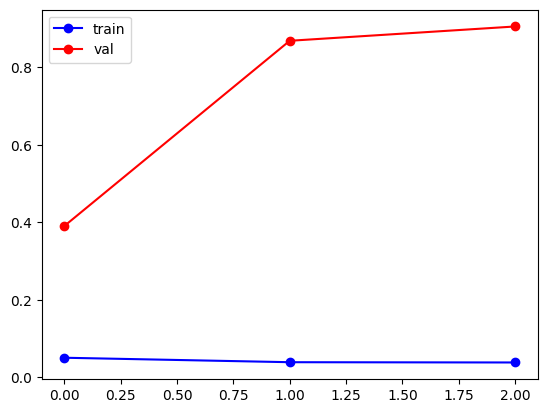

Epoch 4
---------
Train


  0%|          | 0/56 [00:08<?, ?it/s]
2024/11/14 09:07:43 INFO mlflow.tracking._tracking_service.client: üèÉ View run kindly-lynx-60 at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/0/runs/db75b7f39b874d9f9e258de104ebabdf.
2024/11/14 09:07:43 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/0.


KeyboardInterrupt: 

In [ ]:
with mlflow.start_run() as run:

  mlflow.log_param("encoder_length", str(encoder_length))
  mlflow.log_param("decoder_length", decoder_length)
  mlflow.log_param("hidden_size", hidden_size)
  mlflow.log_param("num_lstm_layers", num_lstm_layers)
  # mlflow.log_param("dropout", dropout)
  mlflow.log_param("learning_rate", learning_rate)
  mlflow.log_param("summary", summary(model))
  # mlflow.log_param("teacher_force_probability", teacher_force_probability)
  mlflow.log_param("batch_size", batch_size)

  teacher_force_probability_list = [max(i/num_epoch, 0) for i in range(num_epoch, round(-num_epoch*0.3), -1)]

  y_loss = {}  # loss history
  y_loss['train'] = []
  y_loss['val'] = []
  lr = []


  x_epoch = []
  fig = plt.figure()


  def draw_curve(current_epoch):
      x_epoch.append(current_epoch)
      plt.plot(x_epoch, y_loss['train'], 'bo-', label='train')
      plt.plot(x_epoch, y_loss['val'], 'ro-', label='val')
      # ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
      # ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
      if current_epoch == 0:
          plt.legend()
          # ax1.legend()
      # fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))


  for ix_epoch in range(num_epoch):
      print(f"Epoch {ix_epoch+1}\n---------")
      print("Train")

      teacher_force_probability = teacher_force_probability_list[ix_epoch]
      train_loss = train_model(train_files, model,
                              loss_function,
                              optimizer=optimizer,
                              model_filename=model_filename,
                              batch_size=batch_size,
                              teacher_force_probability=teacher_force_probability)
      print("Test")
      test_loss = test_model(
          test_files, model, loss_function, batch_size=batch_size)

      mlflow.log_metric("train_loss", train_loss, step=ix_epoch)
      mlflow.log_metric("test_loss", test_loss, step=ix_epoch)

      y_loss['train'].append(train_loss)
      y_loss['val'].append(test_loss)

      clear_output(wait=True)
      draw_curve(ix_epoch)
      plt.legend()
      plt.show()

      lr.append(scheduler.get_last_lr())
      scheduler.step(train_loss)

  mlflow.pytorch.log_model(model, "model")


  model_uri = "runs:/{}/model".format(run.info.run_id)
  loaded_model = mlflow.pytorch.load_model(model_uri)



### –û–±—É—á–µ–Ω–∏–µ Seq2Seq

In [ ]:
encoder_length = 600
decoder_length = 300
hidden_size = 512
num_gru_layers = 1
dropout = 0.
learning_rate = 5e-4
teacher_force_probability = 0.5
batch_size = 1024
num_epoch = 10

current_dateTime = "{:%d%m%y}".format(datetime.now())
model_filename = f"seq2seq_{current_dateTime}.pt"

encoder = Encoder(
    enc_feature_size = len(input_data)+len(output_data),
    hidden_size = hidden_size,
    num_gru_layers = num_gru_layers,
    dropout =  dropout
)

# decoder = DecoderWithTeacherForce(
#     dec_feature_size = len(input_data)+len(output_data),
#     dec_target_size = len(output_data),
#     hidden_size = hidden_size,
#     num_gru_layers = num_gru_layers,
#     dropout =  dropout
# )

decoder = Decoder(
    dec_feature_size = len(input_data),
    dec_target_size = len(output_data),
    hidden_size = hidden_size,
    num_gru_layers = num_gru_layers,
    dropout =  dropout
)

# model = Seq2SeqTeacherForce(encoder, decoder)
model = Seq2Seq(encoder, decoder)
# model.load_state_dict(torch.load(f'./{model_filename}'))
model.to(device)
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
‚îú‚îÄEncoder: 1-1                           --
‚îÇ    ‚îî‚îÄGRU: 2-1                          818,688
‚îú‚îÄDecoder: 1-2                           --
‚îÇ    ‚îî‚îÄGRU: 2-2                          801,792
‚îÇ    ‚îî‚îÄLinear: 2-3                       5,643
Total params: 1,626,123
Trainable params: 1,626,123
Non-trainable params: 0

In [ ]:
with mlflow.start_run() as run:
  # mlflow.pytorch.autolog()

  mlflow.log_param("encoder_length", str(encoder_length))
  mlflow.log_param("decoder_length", decoder_length)
  mlflow.log_param("hidden_size", hidden_size)
  mlflow.log_param("num_gru_layers", num_gru_layers)
  mlflow.log_param("dropout", dropout)
  mlflow.log_param("learning_rate", learning_rate)
  mlflow.log_param("summary", summary(model))
  # mlflow.log_param("teacher_force_probability", teacher_force_probability)
  mlflow.log_param("batch_size", batch_size)

  y_loss = {}  # loss history
  y_loss['train'] = []
  y_loss['val'] = []
  # y_err = {}
  # y_err['train'] = []
  # y_err['val'] = []

  x_epoch = []
  fig = plt.figure()
  # ax0 = fig.add_subplot(121, title="loss")
  # ax1 = fig.add_subplot(122, title="top1err")


  def draw_curve(current_epoch):
      x_epoch.append(current_epoch)
      plt.plot(x_epoch, y_loss['train'], 'bo-', label='train')
      plt.plot(x_epoch, y_loss['val'], 'ro-', label='val')
      # ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
      # ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
      if current_epoch == 0:
          plt.legend()
          # ax1.legend()
      # fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))


  for ix_epoch in range(num_epoch):
      print(f"Epoch {ix_epoch+1}\n---------")
      print("Train")
      train_loss = train_model(train_files, model, loss_function, optimizer=optimizer, model_filename=model_filename, batch_size=512)
      print("Test")
      test_loss = test_model(test_files, model, loss_function, batch_size=1024)

      mlflow.log_metric("train_loss", train_loss, step=ix_epoch)
      mlflow.log_metric("test_loss", test_loss, step=ix_epoch)

      y_loss['train'].append(train_loss)
      y_loss['val'].append(test_loss)

      clear_output(wait=True)
      draw_curve(ix_epoch)
      plt.legend()
      plt.show()

  mlflow.pytorch.log_model(model, "model")


  model_uri = "runs:/{}/model".format(run.info.run_id)
  loaded_model = mlflow.pytorch.load_model(model_uri)



Epoch 1
---------
Train


  5%|‚ñå         | 3/56 [00:58<17:11, 19.46s/it]
2024/11/14 06:45:48 INFO mlflow.tracking._tracking_service.client: üèÉ View run nebulous-deer-955 at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/0/runs/380127740f024f228da70a3932a09b73.
2024/11/14 06:45:48 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/0.


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

### –û–±—É—á–µ–Ω–∏–µ Seq2Seq —Å teacher force

In [ ]:
encoder_length = 60
decoder_length = 300
hidden_size = 512
num_gru_layers = 1
dropout = 0.
learning_rate = 5e-4
# teacher_force_probability = 0.5
batch_size = 1024
num_epoch = 10

teacher_force_probability_list = [max(i/num_epoch, 0)
for i in range(num_epoch, round(-num_epoch*0.3), -1)]

current_dateTime = "{:%d%m%y}".format(datetime.now())
model_filename = f"seq2seqTF_{current_dateTime}.pt"

encoder = Encoder(
    enc_feature_size = len(input_data)+len(output_data),
    hidden_size = hidden_size,
    num_gru_layers = num_gru_layers,
    dropout =  dropout
)

decoder = DecoderWithTeacherForce(
    dec_feature_size = len(input_data)+len(output_data),
    dec_target_size = len(output_data),
    hidden_size = hidden_size,
    num_gru_layers = num_gru_layers,
    dropout =  dropout
)


model = Seq2SeqWithTeacherForce(encoder, decoder)
model.to(device)
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

summary(model)

Layer (type:depth-idx)                   Param #
Seq2SeqWithTeacherForce                  --
‚îú‚îÄEncoder: 1-1                           --
‚îÇ    ‚îî‚îÄGRU: 2-1                          818,688
‚îú‚îÄDecoderWithTeacherForce: 1-2           --
‚îÇ    ‚îî‚îÄGRU: 2-2                          818,688
‚îÇ    ‚îî‚îÄLinear: 2-3                       5,643
Total params: 1,643,019
Trainable params: 1,643,019
Non-trainable params: 0

In [ ]:
with mlflow.start_run() as run:

  mlflow.log_param("encoder_length", str(encoder_length))
  mlflow.log_param("decoder_length", decoder_length)
  mlflow.log_param("hidden_size", hidden_size)
  mlflow.log_param("num_lstm_layers", num_gru_layers)
  # mlflow.log_param("dropout", dropout)
  mlflow.log_param("learning_rate", learning_rate)
  mlflow.log_param("summary", summary(model))
  # mlflow.log_param("teacher_force_probability", teacher_force_probability)
  mlflow.log_param("batch_size", batch_size)

  teacher_force_probability_list = [max(i/num_epoch, 0) for i in range(num_epoch, round(-num_epoch*0.3), -1)]

  y_loss = {}  # loss history
  y_loss['train'] = []
  y_loss['val'] = []


  x_epoch = []
  fig = plt.figure()


  def draw_curve(current_epoch):
      x_epoch.append(current_epoch)
      plt.plot(x_epoch, y_loss['train'], 'bo-', label='train')
      plt.plot(x_epoch, y_loss['val'], 'ro-', label='val')
      if current_epoch == 0:
          plt.legend()

  for ix_epoch in range(num_epoch):
      print(f"Epoch {ix_epoch+1}\n---------")
      print("Train")

      teacher_force_probability = teacher_force_probability_list[ix_epoch]
      train_loss = train_model(train_files, model,
                              loss_function,
                              optimizer=optimizer,
                              model_filename=model_filename,
                              batch_size=batch_size,
                              teacher_force_probability=teacher_force_probability)
      print("Test")
      test_loss = test_model(
          test_files, model, loss_function, batch_size=batch_size)

      mlflow.log_metric("train_loss", train_loss, step=ix_epoch)
      mlflow.log_metric("test_loss", test_loss, step=ix_epoch)

      y_loss['train'].append(train_loss)
      y_loss['val'].append(test_loss)

      clear_output(wait=True)
      draw_curve(ix_epoch)
      plt.legend()
      plt.show()

  mlflow.pytorch.log_model(model, "model")

  model_uri = "runs:/{}/model".format(run.info.run_id)
  loaded_model = mlflow.pytorch.load_model(model_uri)

Epoch 1
---------
Train


 21%|‚ñà‚ñà‚ñè       | 12/56 [01:45<06:25,  8.77s/it]
2024/11/14 07:33:58 INFO mlflow.tracking._tracking_service.client: üèÉ View run able-foal-302 at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/0/runs/bcb6a7c2c3464febb8b344b30874cdbf.
2024/11/14 07:33:58 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: https://dagshub.com/pranamodeling/seq2seq-gtd-6rm.mlflow/#/experiments/0.


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>